### Libraries:

In [252]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import svd, eig
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, eigs
import re
import gensim
import seaborn as sns
from scipy import stats

### Prepearing data:

In [254]:
file = open("test_2.txt", "r")

doclist = [line for line in file]    
docstr = ''.join(doclist)
sentences = re.split(r'[.!?]', docstr)
sentences = [sentence.split() for sentence in sentences if len(sentence) > 1]

In [ ]:
print("Number of sentences:", len(sentences))
print("Example of sentence:", sentences[10])

In [ ]:
def create_vocabulary(sentences, d=150): 
    vocabulary = {}
    wordfreq = {}
    i = 0
    for s in sentences:
        for w in s:
            if w not in wordfreq:
                wordfreq[w] = 0 
            wordfreq[w] += 1
    for word in wordfreq:
        if (wordfreq[word] >= d):
            vocabulary[word] = i
            i += 1
    return vocabulary

In [ ]:
vocabulary = create_vocabulary(sentences)

In [ ]:
print("Dimension of vocabulary:", len(vocabulary))

### SPPMI via truncated SVD

In [ ]:
def create_corpus_matrix(sentences, vocabulary):
    n = len(vocabulary)
    corpus_matrix = np.zeros((n, n))
    
    for sentense in sentences:
        for position_of_word in range(len(sentense)):
            window = [-2, -1, 0, 1, 2]
            for i in window:
                if (position_of_word + i) in range(0, len(sentense)):
                    word = sentense[position_of_word]
                    context = sentense[i]
                    if if_in_vocabulary(word, context) and i != position_of_word:
                        corpus_matrix[vocabulary[word]][vocabulary[context]] += 1
                
    return corpus_matrix

In [ ]:
D = create_corpus_matrix(sentences, vocabulary)

In [79]:
def compute_embeddings(D, k=5, d=150):
    n = D.shape[0]
    SPPMI = np.zeros((n,n), dtype=float)
    w = np.sum(D, axis=1)
    m = np.sum(w)
    l = np.log(m/k)
    for i in range(n):
        for j in range(n):
            if (D[i,j]!=0):
                f = np.log(D[i,j]/w[i]/w[j]) + l
                if (f>0): SPPMI[i,j] = f
    SPPMI = csr_matrix(SPPMI)
    
#     u, s, _ = svds(SPPMI, k=d)  
#     return u.dot(np.diag(np.sqrt(s))) #embedding_matrix

    return SPPMI

In [80]:
M = compute_embeddings(D, d=150)

In [81]:
u, s, v = svds(M, k=700)

### Word2vec via gensim library

In [84]:
model = gensim.models.Word2Vec(sentences, min_count=150, size=700)    

In [85]:
def create_wv_vocabs(model):
    enum_vocab = {}
    rev_vocab = {}
    for i in range(len(model.wv.vocab)):
        word = model.wv.similar_by_vector(model.wv.vectors[i], 1)[0][0]
        rev_vocab[i] = word
        enum_vocab[word] = i
    return rev_vocab, enum_vocab

In [86]:
iwvoc, wivoc = create_wv_vocabs(model)

/Users/kmps/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [87]:
revvoc = {v: k for k, v in vocabulary.items()}

In [137]:
#sgns
for i in np.argsort(model.wv.vectors[:, 699])[-20:]:
    print (iwvoc[i])

seems
belongs
find
depends
provides
isn
is
distinguish
governor
refers
history
iraq
goes
appeared
refer
takes
kingdom
be
deleted
appears


In [147]:
np.argsort(u[:, 0])[:-20].shape

(15585,)

In [230]:
len(u[:, 697])

15605

In [263]:
for i in np.argsort(u[:, 659])[-20:]:
    print(revvoc[i])

trumpet
recorder
percussion
strings
electric
keyboard
manufacturer
string
horn
harp
alto
soprano
concerto
viola
cello
saxophone
violin
clarinet
piano
flute


### Eigenvectors distibution 

#### The null hypothesis check

In [43]:
def is_normal(vec):
    k2, p = stats.normaltest(vec.real)
    print(p)
# null hypothesis: x comes from a normal distribution
    if p < 1e-100:  
        print("The null hypothesis can be rejected")
        return False
    else:
        print("The null hypothesis cannot be rejected")
        return True

#### a) SVD

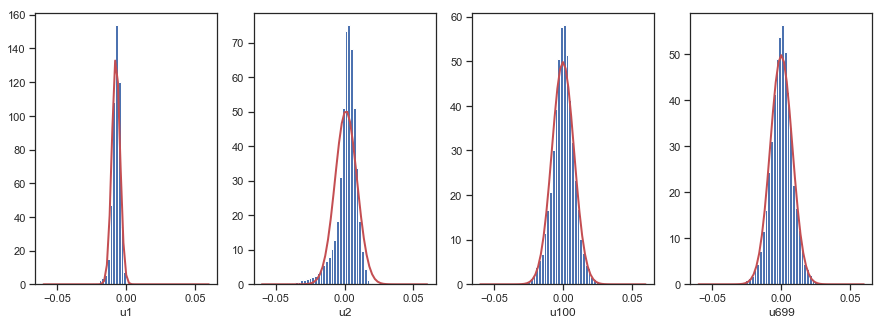

In [114]:
eig_list_svd = [u[:, 699], u[:, 698], u[:, 299], u[:, 0]] 
eig_list_names = ['u1', 'u2', 'u401', 'u699']
plt.figure(figsize=(15,5))

for i, eig in enumerate(eig_list_svd):
    a = eig 
    mu = np.mean(a)
    sigma = np.std(a)
    
    plt.subplot(1, 4, i+1)
    count, bins, ignored = plt.hist(a, 60, density = True, color='b', range =(-0.06, 0.06))
    plt.plot(bins, 1/(sigma*(np.sqrt(2 * np.pi))) * np.exp(- (bins-mu)**2 /(2*sigma**2) ), linewidth=2, color='r')
    plt.xlabel('%s'% eig_list_names[i], fontsize=12)
      
plt.savefig('svg_eig.png')
plt.show()

In [115]:
for vec in eig_list_svd:
    is_normal(vec)

0.0
The null hypothesis can be rejected
0.0
The null hypothesis can be rejected
1.789496546791768e-96
The null hypothesis cannot be rejected
3.917062687701434e-64
The null hypothesis cannot be rejected


#### b) SGNS

In [109]:
#SVD for SGNS
ug, sg, vhg = scipy.linalg.svd(model.wv.vectors, full_matrices=False)

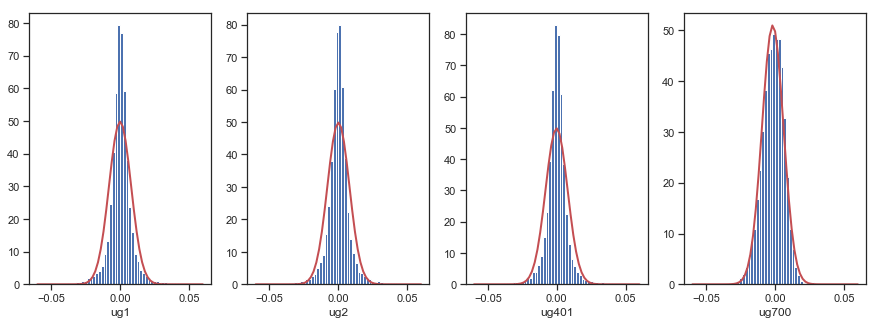

In [134]:
eig_list_sgns = [ug[:, len(ug[0])-1], ug[:, len(ug[0])-2], ug[:, 299], ug[:, 0]]
eig_list_names = ['ug1', 'ug2', 'ug401', 'ug700']
plt.figure(figsize=(15,5))

for i, eig in enumerate(eig_list_sgns):
    a = eig 
    mu = np.mean(a)
    sigma = np.std(a)
    
    plt.subplot(1, 4, i+1)
    count, bins, ignored = plt.hist(a, 60, density = True, color='b', range =(-0.06, 0.06))
    plt.plot(bins, 1/(sigma*(np.sqrt(2 * np.pi))) * np.exp(- (bins-mu)**2 /(2*sigma**2) ), linewidth=2, color='r')
    plt.xlabel('%s'% eig_list_names[i], fontsize=12)
      
plt.savefig('sgns_eig.png')
plt.show()

In [135]:
for vec in eig_list_sgns:
    is_normal(vec)

0.0
The null hypothesis can be rejected
0.0
The null hypothesis can be rejected
0.0
The null hypothesis can be rejected
8.209404489120923e-38
The null hypothesis cannot be rejected


## Inverse Participation Ratio (IPR)

### SVD and  SGNS IPR distributions

In [118]:
iprwv = np.sum(model.wv.vectors**4, axis=0) / np.linalg.norm(model.wv.vectors, axis=0)**4

In [119]:
ipr = np.sum(u**4, axis=0)

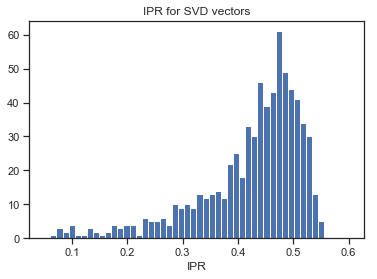

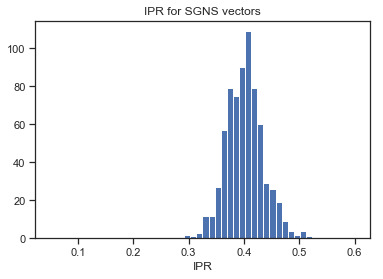

In [136]:
plt.hist(1/ipr/7722, bins=50, range=(0.05, 0.6)) 
plt.title('IPR for SVD vectors') 
plt.xlabel('IPR') 
plt.savefig('IPR_SVD.png')
plt.show()

plt.hist(1/iprwv/7722, bins=50, range=(0.05, 0.6)) 
plt.title('IPR for SGNS vectors') 
plt.xlabel('IPR') 
plt.savefig('IPR_SGNS.png')
plt.show()

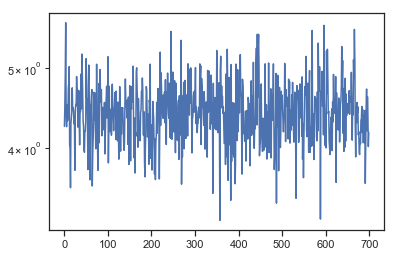

In [132]:
plt.semilogy(1/iprwv/len(iprwv))
plt.show()

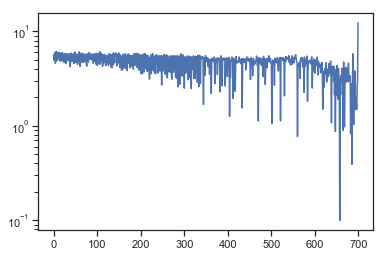

In [133]:
plt.semilogy(1/ipr/len(ipr))
plt.show()

### Check of normal distribution 

#### For SVD

In [125]:
is_normal(ipr)

0.0
The null hypothesis can be rejected


False

#### For SGNS

In [127]:
is_normal(iprwv)

8.658704106017392e-07
The null hypothesis cannot be rejected


True

###  vectors with highest IPR 

In [266]:
#SVD first three vectors with highest IPR 
max_ipr = [i for i in np.argsort(ipr)]
for i in max_ipr[0:3]:
    print('u%d:'%i)
    for j in np.argsort(u[:,i])[:20]:
        print(iwvoc[j])
    print('*****')

u699:
hook
brooks
carving
starts
fighter
online
relative
powered
storm
supposedly
dave
logo
harris
captivity
depends
reliability
somewhere
plate
liver
breaking
*****
u6:
regiments
fever
willis
takeoff
gather
tsar
statesman
trend
ac
gift
zoom
literacy
contracted
ore
drives
gonna
doesn
fiscal
theta
aviation
*****
u106:
perpendicular
clans
laden
divinity
sandra
rdoba
unknown
assessment
partnership
endeavour
merger
judge
keyboard
identifying
ronald
vat
fur
public
napier
dumbledore
*****


In [265]:
#SGNS first three vectors with highest IPR 
max_iprwv = [i for i in np.argsort(iprwv)]

for i in max_iprwv[:3]:
    print(i)
    for j in np.argsort(ug[:,i])[-20:]:
        print( iwvoc[j])
    print('*****')

3
leave
injured
attack
hit
knocked
escape
him
caught
returned
fought
sailed
troops
forced
thrown
wounded
shot
defeated
fight
fired
killed
*****
596
september
being
natural
here
movie
within
cover
arms
per
search
memory
prize
service
training
others
good
henry
german
american
puerto
*****
666
each
example
charles
standard
financial
non
stock
student
stone
you
this
today
an
san
speed
called
france
police
e
network
*****
